In [7]:
import pandas as pd




In [9]:
import json
import requests
import pandas as pd   


from scipy import fftpack
import matplotlib.pyplot as plt
import numpy as np
from websocket import create_connection,WebSocket

import time





In [192]:


def pullStats(uri):
    
    
    
    ws = create_connection(uri)

    sysstats = json.loads(ws.recv())["data"]
    ms = json.loads(ws.recv())["data"]
    cs = json.loads(ws.recv())["data"]
    ws.close()



    
    if len(ms)>0:
        df = pd.DataFrame(ms)
    else:
        df = pd.DataFrame([{}],columns=["dur","date"])
    
    df["date"] = pd.to_datetime(df["date"],unit="s")
    df = df.set_index("date")
    dfm = df.copy()

    # camera frame
    if len(cs)>0:
        df = pd.DataFrame(cs)
        df["date"] = pd.to_datetime(df["triggerDate"],unit="s")
        df = df.drop(columns=["triggerDate"])

        dfup = pd.json_normalize(df["usedParams"])
        dfup = dfup.rename(columns={ c:"up_"+c for c in dfup.columns})
        df = df.join(dfup)
        df = df.drop(columns=["usedParams"])
        

        dfc = df.copy()
    else:
        dfc = None
    
    return dfm,dfc,sysstats


<AxesSubplot:xlabel='date'>

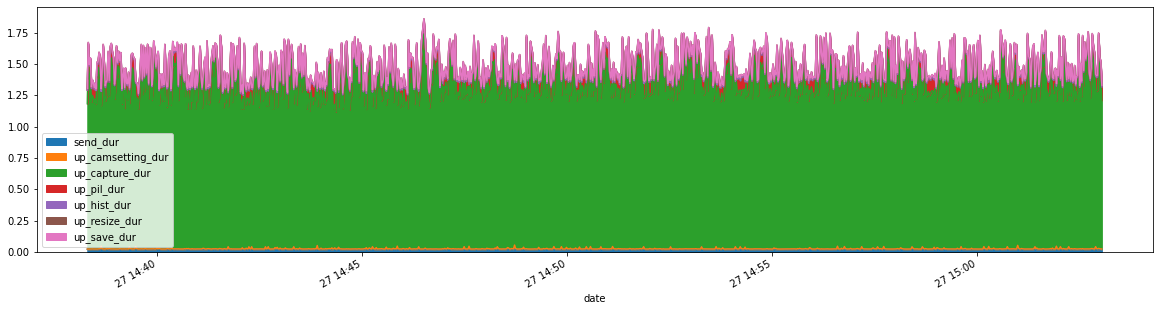

In [210]:

uri = "ws://192.168.1.85:8765/stats"


dfm,dfc,sysstats = pullStats(uri)


durcols = [c for c in dfc.columns if "_dur" in c]
dfc.set_index("date")[durcols].plot.area(figsize=(20,5))

<AxesSubplot:xlabel='up_exposure_speed'>

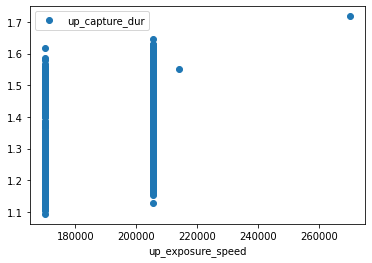

In [211]:
dfcfilt = dfc[list(map(lambda x: [3296, 2464] ==x ,dfc["up_imageSize"]))]

dfcfilt = dfcfilt[dfcfilt["up_capture_format"] == "rgb"]


dfcfilt.set_index("up_exposure_speed")[["up_capture_dur"]].plot(style="o")

<AxesSubplot:xlabel='up_exposure_speed'>

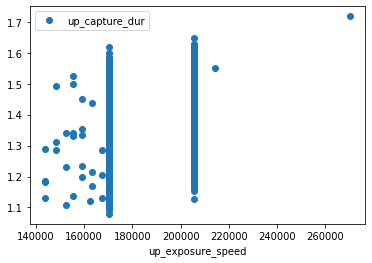

In [208]:
dfcfilt[dfcfilt["up_exposure_speed"]<=500000].set_index("up_exposure_speed")[["up_capture_dur"]].plot(style="o")

In [209]:
import numpy as np
from scipy import stats

linreg= stats.linregress(dfcfilt["up_exposure_speed"]/(1000000),  dfcfilt ["up_capture_dur"])
linreg

LinregressResult(slope=1.1396613251231926, intercept=1.1098413523942656, rvalue=0.15454899524895868, pvalue=9.075712512400026e-07, stderr=0.23061882764821032, intercept_stderr=0.043375075726617)

In [212]:
sysstats

[{'total': 28.196147918701172,
  'used': 2.5555572509765625,
  'usedpct': 9.063497816599202,
  'free': 24.46503448486328,
  'disk': '/'},
 {'total': 3.758800506591797,
  'used': 0.01143646240234375,
  'usedpct': 0.3042582968233526,
  'free': 3.747364044189453,
  'disk': '/dev/shm'}]

In [58]:


uri = "ws://192.168.1.85:8765/stats"


dfm,dfc,sysstats = pullStats(uri)
dfm.drop(columns=["rspd"]).plot(figsize=(20,10))
dfc.tail(500).plot.area(figsize=(20,5))
len(dfm)

KeyError: "['rspd'] not found in axis"

'var 0.0064'

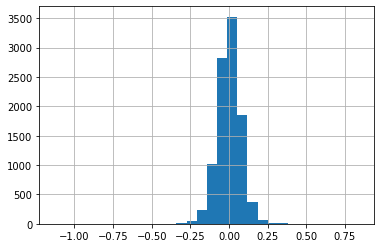

In [86]:
dfm["err"].hist(bins=30)
"var %.4f"%dfm["err"].var()

In [87]:
"revar1?? %.3f%%"%(np.abs(dfm["err"].var()/dfm["ts"].mean())*100)

'revar1?? 0.544%'

'revar2?? 2.166%'

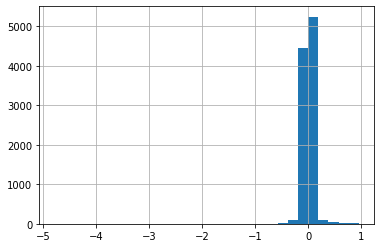

In [88]:

#calculate relative error
dfm["relerrpct"] = ((dfm["err"]/dfm["ts"]))
dfm["relerrpct"].hist(bins=30)
"revar2?? %.3f%%"%(dfm["relerrpct"].var()*100)

Text(0, 0.5, 'Phase')

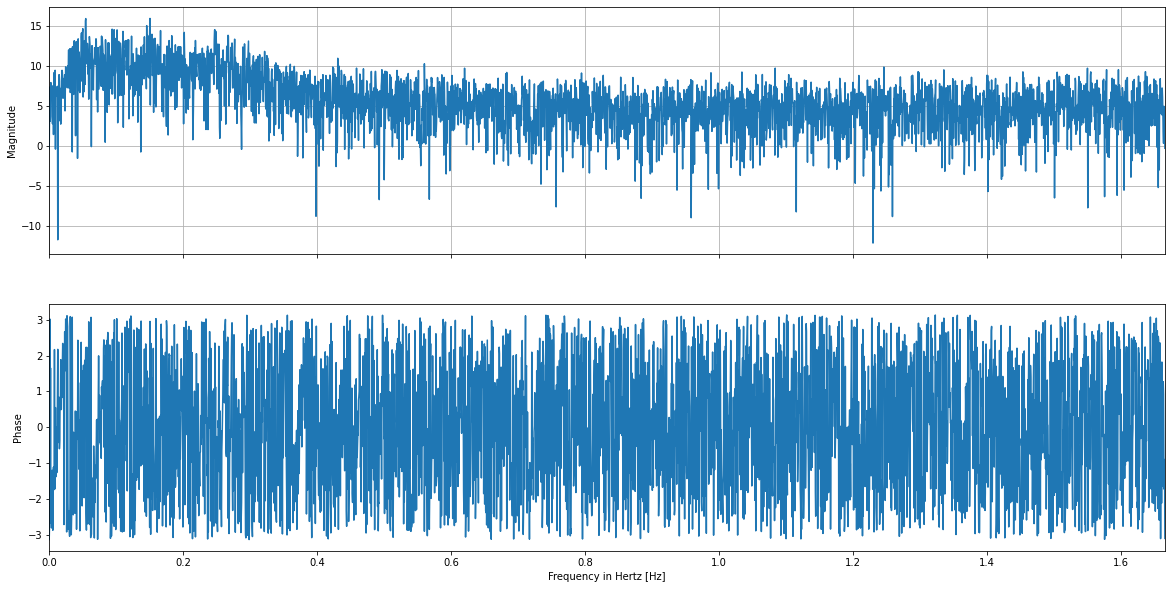

In [89]:

def makeFFT(dfm):
    f_s = 1.0/0.3
    x = dfm.resample('.3S').mean()["err"].values


    X = fftpack.fft(x)
    freqs = fftpack.fftfreq(len(x)) * f_s


    cutat = int(len(X)/2)
    
    return freqs,X,cutat,f_s


freqs,X,cutat,f_s = makeFFT(dfm)




fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

#plt.xscale("log")

axm = axes[0]
dolog = True
if dolog:
    t = 10*np.log10(np.abs(X))
else:
    t = np.abs(X)
axm.plot(freqs[:cutat],t[:cutat])

axm.set_ylabel('Magnitude')
axm.grid(True)
axm.set_xlim(0, f_s / 2)

axp = axes[1]
axp.plot(freqs[:cutat], np.angle(X)[:cutat])
axp.set_xlabel('Frequency in Hertz [Hz]')
axp.set_ylabel('Phase')


In [90]:


def makemsg(k,v): return json.dumps({"msgtype":"ctlparams","k":k,"v":v})

def settingTargetSpeed(uri,val):
    print("setting speed to .3f"%val)
    ws = create_connection(uri)
    ws.send(makemsg("T",val))

    ws.close()

def settingPID(uri,P,I,D):
    ws = create_connection(uri)
    ws.send(makemsg("P",P))
    time.sleep(.300)
    ws.send(makemsg("I",I))
    time.sleep(.300)
    ws.send(makemsg("D",D))
    time.sleep(.300)
    ws.close()

,dur
0,NaN


In [30]:
uri = "ws://192.168.1.85:8765/stats"
ws = create_connection(uri)

sysstats = ws.recv()
motorstats = ws.recv()
camstats = ws.recv()
ws.close()

sysstats,motorstats,camstats

('{"msgtype": "sysInfo", "data": [{"total": 28.196147918701172, "used": 2.5538597106933594, "usedpct": 9.057477347817093, "free": 24.466732025146484, "disk": "/"}, {"total": 3.758800506591797, "used": 8.7738037109375e-05, "usedpct": 0.0023342030776975016, "free": 3.7587127685546875, "disk": "/dev/shm"}]}',
 '{"msgtype": "motorstats", "data": []}',
 '{"msgtype": "camstats", "data": [{"triggerDate": 1616852311.0366006, "camsetting_dur": 0.002622842788696289, "capture_dur": 0.5460569858551025, "pil_dur": 0.0024514198303222656, "hist_dur": 1.1920928955078125e-06, "resize_dur": 0.003107786178588867, "save_dur": 0.0008327960968017578, "send_dur": 0.035123586654663086, "usedParams": {"triggerDate": 1616852311.0366006, "gains": [1.0, 1.0], "analog_gain": 1.0, "iso": 100, "brightness": 50, "saturation": 0, "contrast": 0, "exposure_compensation": 0, "resolution": [480, 368], "imageSize": [480, 368], "shutterSpeed": 149999, "exposure_speed": 20000, "exposure_mode": "off", "awb_mode": "off", "capt

In [13]:
data

'{"msgtype": "sysInfo", "data": [{"total": 931.4960899353027, "used": 606.1567573547363, "usedpct": 65.07346234774181, "free": 325.3393325805664, "disk": "/"}, {"total": 931.4960899353027, "used": 606.1567573547363, "usedpct": 65.07346234774181, "free": 325.3393325805664, "disk": "/dev/shm"}]}'

In [29]:
uri = "ws://192.168.1.85:8765"


settingPID(uri,80,20,-15)

settingTargetSpeed(uri,0)

# wait to stabilize
time.sleep(30)


settingTargetSpeed(uri,-1.5)
# wait to stabilize
#time.sleep(60)


# read results

NameError: name 'settingPID' is not defined

In [60]:
settingPID(uri,150,0,0)
# wait to stabilize
time.sleep(30)

In [ ]:
#.resample("1T").mean()

<AxesSubplot:xlabel='date'>

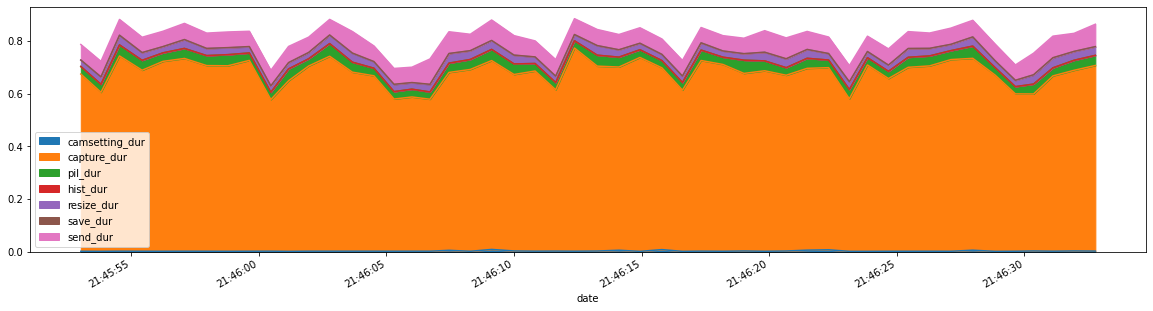

In [38]:
dfc.tail(50).plot.area(figsize=(20,5))
